In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
sns.set_style("dark")
plt.rcParams["font.family"] = "monospace"

In [ ]:
     0.287 ms | Pre-text-encoder
   126.231 ms | _encode_prompt
     0.174 ms | Prepare timesteps
     0.489 ms | Prepare latents
     0.114 ms | prepare_extra_step_kwargs
  6770.368 ms | Denoising loop - reverse diffusion (UNet) for 20 timesteps
   234.663 ms | VAE Decoder (Unet decoder)
   323.877 ms | post-process such as numpy_to_pil
  7456.203 ms | End-to-End

# Latency by Major Block

In [9]:
df_majorblock = pd.read_csv("./ordered_majorblock_latency.csv")

In [10]:
df_majorblock.scope_mean.sum() # validate this against report

6.194130192883311

In [11]:
df_majorblock.head(3)

,Unnamed: 0,scope,module_type,scope_mean,scope_percentage
0,0,down_blocks.0,CrossAttnDownBlock2D,1.303475,21.043713
1,1,down_blocks.1,CrossAttnDownBlock2D,0.439676,7.098265
2,2,down_blocks.2,CrossAttnDownBlock2D,0.373335,6.027231


In [12]:
colorlut = dict(zip(df_majorblock.scope[0:4], plt.cm.RdBu(np.linspace(0.6,0.9, 4)[::-1])))
colorlut[df_majorblock.scope[4]] = "lightgreen"
for k, v in zip(df_majorblock.scope[5:9], plt.cm.RdBu(np.linspace(0.1,0.4, 4)[::-1])):
    colorlut[k]=v
colorlut[df_majorblock.scope[9]] = "lightslategray"

In [13]:
colorlut

{'down_blocks.0': array([0.12725875, 0.39584775, 0.66874279, 1.        ]),
 'down_blocks.1': array([0.2627451 , 0.57647059, 0.76470588, 1.        ]),
 'down_blocks.2': array([0.56647443, 0.76870434, 0.86851211, 1.        ]),
 'down_blocks.3': array([0.81960784, 0.89803922, 0.94117647, 1.        ]),
 'mid_block': 'lightgreen',
 'up_blocks.0': array([0.99215686, 0.85882353, 0.78039216, 1.        ]),
 'up_blocks.1': array([0.95455594, 0.64175317, 0.50572857, 1.        ]),
 'up_blocks.2': array([0.83921569, 0.37647059, 0.30196078, 1.        ]),
 'up_blocks.3': array([0.6922722 , 0.0922722 , 0.16770473, 1.        ]),
 'others': 'lightslategray'}

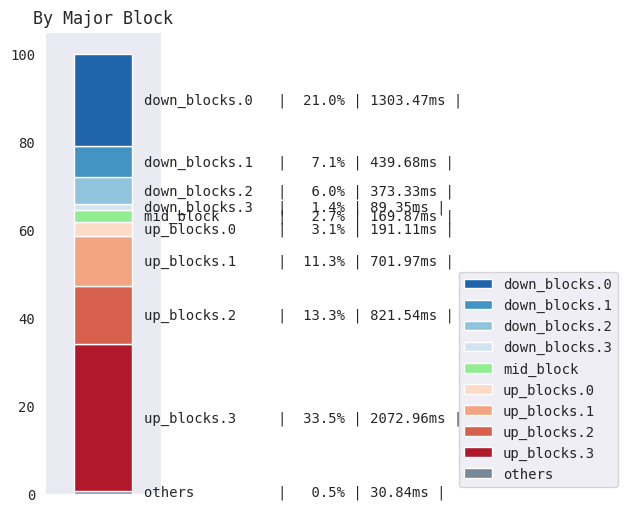

In [14]:
stacked_majorblock = df_majorblock[['scope', 'scope_percentage']]
stacked_majorblock.set_index('scope', inplace=True)
stacked_majorblock = stacked_majorblock.reindex(index=stacked_majorblock.index[::-1]).T
ax = stacked_majorblock.plot.bar(stacked=True, color=colorlut, figsize=(1.5, 6), title = "By Major Block")
ax.legend(loc='lower left', bbox_to_anchor=(3.5,0.0), reverse=True)
ax.axes.get_xaxis().set_visible(False)

for k, p in zip(stacked_majorblock.columns, ax.patches):
    scope_mean = df_majorblock.set_index('scope').loc[k, "scope_mean"]
    scope_pc = df_majorblock.set_index('scope').loc[k, "scope_percentage"]

    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width+0.1, 
            y+height/2, 
            f'{k:15} | {scope_pc:5.1f}% | {scope_mean*1000:5.2f}ms | ', 
            horizontalalignment='left', 
            verticalalignment='center')

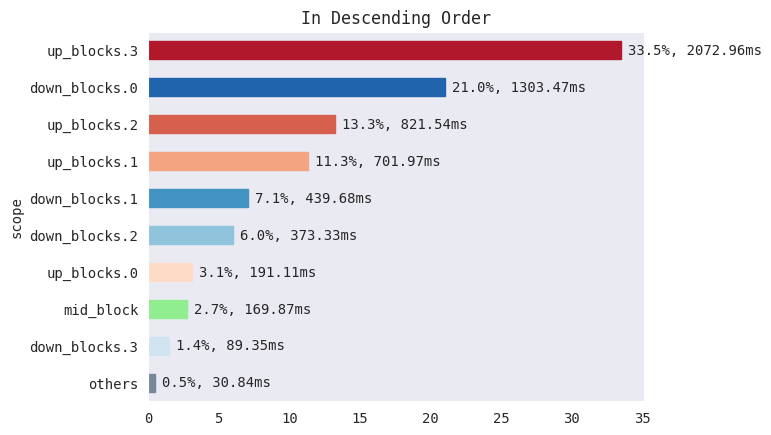

In [15]:
sorted_df_majorblock =  df_majorblock.set_index('scope').sort_values('scope_percentage')
ax =sorted_df_majorblock.plot.barh(y=['scope_percentage'], legend=False, title="In Descending Order")
# TODO: color to match above

for key, p, relval, absval  in zip(sorted_df_majorblock.index, ax.patches, sorted_df_majorblock['scope_percentage'], sorted_df_majorblock['scope_mean']):
    p.set_color(colorlut[key])
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width+0.5, 
            y+height/2, 
            f'{relval:.1f}%, {absval*1000:.2f}ms', 
            horizontalalignment='left', 
            verticalalignment='center')

# Latency by Super Block

In [16]:
df_majorblock = pd.read_csv("./ordered_majorblock_latency_for_superblock.csv")

In [17]:
df_majorblock.groupby('module_type').sum()

,Unnamed: 0,scope,scope_mean,scope_percentage
module_type,,,,
Down_SuperBlock,6,down_blocks-64down_blocks-32down_blocks-16down...,2.205839,35.611768
Mid_SuperBlock,5,mid_block,0.169871,2.742453
Up_SuperBlock,25,UpBlock-8UpBlock-16UpBlock-32UpBlock-64,3.787575,61.147814
misc,9,others,0.030845,0.497965


In [18]:
tempdf = df_majorblock.groupby('module_type').sum().reset_index()
df_superblock=tempdf[['module_type','scope_mean', 'scope_percentage']].rename(columns={"module_type":"scope"})

In [19]:
df_superblock

,scope,scope_mean,scope_percentage
0,Down_SuperBlock,2.205839,35.611768
1,Mid_SuperBlock,0.169871,2.742453
2,Up_SuperBlock,3.787575,61.147814
3,misc,0.030845,0.497965


In [20]:
df_superblock.scope

0    Down_SuperBlock
1     Mid_SuperBlock
2      Up_SuperBlock
3               misc
Name: scope, dtype: object

In [21]:
plt.cm.RdBu(np.linspace(0.6,0.9, 4)[::-1])[0]

array([0.12725875, 0.39584775, 0.66874279, 1.        ])

In [22]:
colorlut = dict()
colorlut[df_superblock.scope[0]]=plt.cm.RdBu(np.linspace(0.6,0.9, 4)[::-1])[0]
colorlut[df_superblock.scope[1]] = "lightgreen"
colorlut[df_superblock.scope[2]] = plt.cm.RdBu(np.linspace(0.1,0.4, 4))[0]
colorlut[df_superblock.scope[3]] = "lightslategray"

In [23]:
colorlut

{'Down_SuperBlock': array([0.12725875, 0.39584775, 0.66874279, 1.        ]),
 'Mid_SuperBlock': 'lightgreen',
 'Up_SuperBlock': array([0.6922722 , 0.0922722 , 0.16770473, 1.        ]),
 'misc': 'lightslategray'}

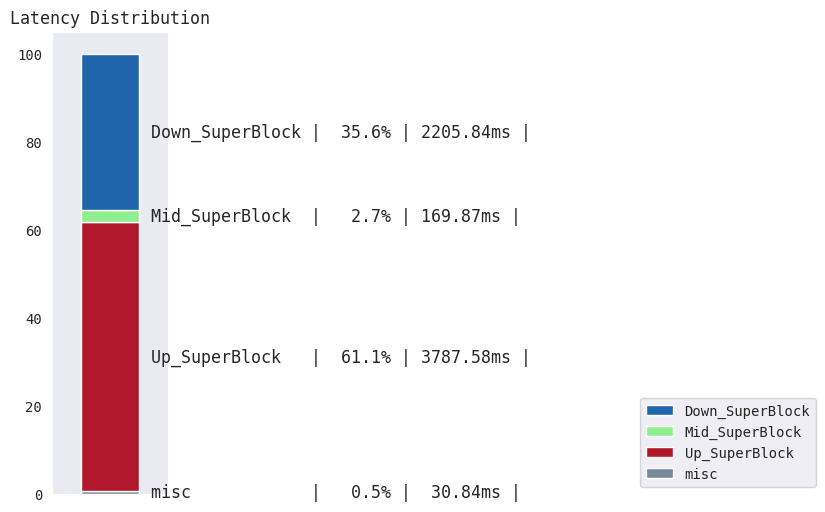

In [24]:
stacked_superblock = df_superblock[['scope', 'scope_percentage']]
stacked_superblock.set_index('scope', inplace=True)
stacked_superblock = stacked_superblock.reindex(index=stacked_superblock.index[::-1]).T
ax = stacked_superblock.plot.bar(stacked=True, color=colorlut, figsize=(1.5, 6), title = "Latency Distribution")
ax.legend(loc='lower left', bbox_to_anchor=(5,0.0), reverse=True)
ax.axes.get_xaxis().set_visible(False)

for k, p in zip(stacked_superblock.columns, ax.patches):
    scope_mean = df_superblock.set_index('scope').loc[k, "scope_mean"]
    scope_pc = df_superblock.set_index('scope').loc[k, "scope_percentage"]

    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width+0.1, 
            y+height/2, 
            f'{k:15} | {scope_pc:5.1f}% | {scope_mean*1000:6.2f}ms | ', 
            horizontalalignment='left', 
            verticalalignment='center', size=12)

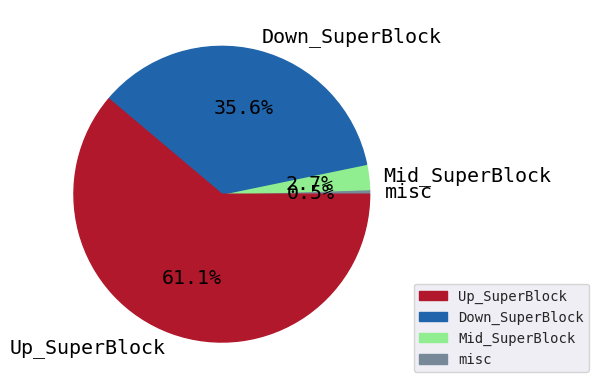

In [25]:
df_superblock_pie = df_superblock.sort_values("scope_mean").set_index("scope")
ax=df_superblock_pie.plot.pie(y="scope_mean", autopct='%.1f%%', textprops={'size': 'x-large', 'color':'black'})
ax.axes.get_yaxis().set_visible(False)

for k, p in zip(df_superblock_pie.index, ax.patches):
    p.set_color(colorlut[k])

# because we remap color, putting/updating legend at last will reflect new color
ax.legend(loc='lower left', bbox_to_anchor=(1,0.0), reverse=True)

# Latency by Main Block Type

In [46]:
df_mainblock = pd.read_csv("./manual_res_tx_latency.csv")

In [47]:
df_mainblock.groupby('module_type').count()

,Unnamed: 0,scope,scope_mean,scope_percentage
module_type,,,,
ResnetBlock2D,22,22,22,22
Transformer2DModel,16,16,16,16
others,1,1,1,1


In [48]:
tempdf = df_mainblock.groupby('module_type').sum().reset_index()
df_mainblock_summ=tempdf[['module_type','scope_mean', 'scope_percentage']].rename(columns={"module_type":"scope"}).sort_values("scope_percentage", ascending=False)

In [49]:
resnet_color = "#99CCFF"
transformer_color = "#CCFF99"

In [50]:
df_mainblock_summ.scope

1    Transformer2DModel
0         ResnetBlock2D
2                others
Name: scope, dtype: object

In [51]:
colorlut = dict()
colorlut[df_mainblock_summ.scope[0]] = resnet_color
colorlut[df_mainblock_summ.scope[1]] = transformer_color
colorlut[df_mainblock_summ.scope[2]] = "lightslategray"

In [52]:
colorlut

{'ResnetBlock2D': '#99CCFF',
 'Transformer2DModel': '#CCFF99',
 'others': 'lightslategray'}

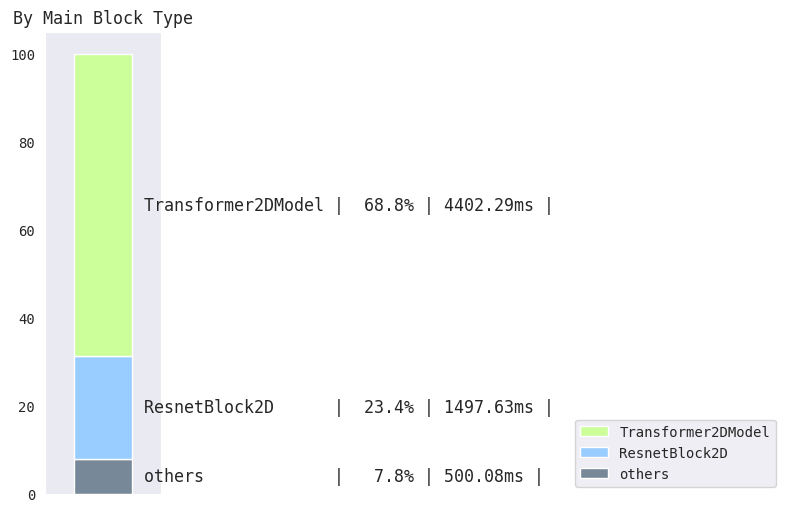

In [53]:
stacked_mainblock_summ = df_mainblock_summ[['scope', 'scope_percentage']]
stacked_mainblock_summ.set_index('scope', inplace=True)
stacked_mainblock_summ = stacked_mainblock_summ.reindex(index=stacked_mainblock_summ.index[::-1]).T
ax = stacked_mainblock_summ.plot.bar(stacked=True, color=colorlut, figsize=(1.5, 6), title = "By Main Block Type")
ax.legend(loc='lower left', bbox_to_anchor=(4.5,0.0), reverse=True)
ax.axes.get_xaxis().set_visible(False)

for k, p in zip(stacked_mainblock_summ.columns, ax.patches):
    scope_mean = df_mainblock_summ.set_index('scope').loc[k, "scope_mean"]
    scope_pc = df_mainblock_summ.set_index('scope').loc[k, "scope_percentage"]

    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width+0.1, 
            y+height/2, 
            f'{k:18} | {scope_pc:5.1f}% | {scope_mean*1000:6.2f}ms | ', 
            horizontalalignment='left', 
            verticalalignment='center', size=12)

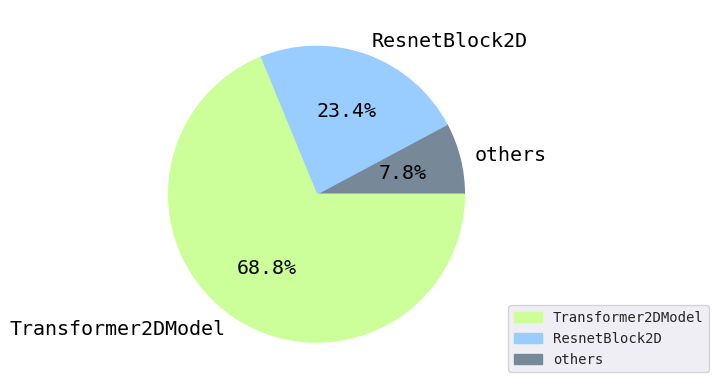

In [54]:
df_mainblock_summ_pie = df_mainblock_summ.sort_values("scope_mean").set_index("scope")
ax=df_mainblock_summ_pie.plot.pie(y="scope_mean", autopct='%.1f%%', textprops={'size': 'x-large', 'color':'black'})
ax.axes.get_yaxis().set_visible(False)

for k, p in zip(df_mainblock_summ_pie.index, ax.patches):
    p.set_color(colorlut[k])

# because we remap color, putting/updating legend at last will reflect new color
ax.legend(loc='lower left', bbox_to_anchor=(1,0.0), reverse=True)

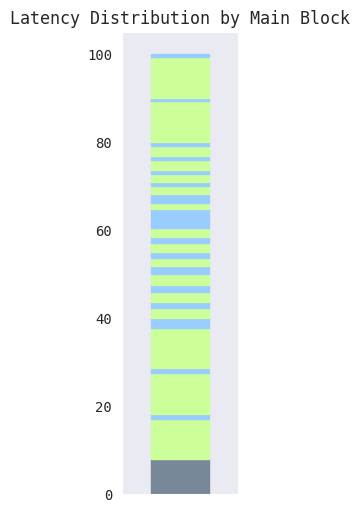

In [55]:
stacked_mainblock = df_mainblock[['scope', 'scope_percentage']]
stacked_mainblock.set_index('scope', inplace=True)
stacked_mainblock = stacked_mainblock.reindex(index=stacked_mainblock.index[::-1]).T
# color handling is different from above due to type based, see loop below
ax = stacked_mainblock.plot.bar(stacked=True, figsize=(1.5, 6), title = "Latency Distribution by Main Block", legend=None)
ax.axes.get_xaxis().set_visible(False)

for k, p in zip(stacked_mainblock.columns, ax.patches):
    module_type = df_mainblock.set_index('scope').loc[k, "module_type"]
    p.set_color(colorlut[module_type])

    # width, height = p.get_width(), p.get_height()
    # x, y = p.get_xy() 
    # ax.text(x+width+0.1, 
    #         y+height/2, 
    #         f'{k:15} | {scope_pc:5.1f}% | {scope_mean*1000:5.2f}ms | ', 
    #         horizontalalignment='left', 
    #         verticalalignment='center')

# Latency by Layer Type (for some reason, spr15 linear or conv2d doesn't have layer wise data, debug required)

In [212]:
df_layer = pd.read_csv("./manual_layer_latency.csv")

In [218]:
df_layer.groupby("module_type").count()

,scope,scope_mean,scope_percentage
module_type,,,
Conv2d,98,98,98
Linear,184,184,184
others,1,1,1


In [220]:
tempdf = df_layer.groupby('module_type').sum().reset_index()
df_layer_summ=tempdf[['module_type','scope_mean', 'scope_percentage']].rename(columns={"module_type":"scope"}).sort_values("scope_percentage", ascending=False)

In [221]:
df_layer_summ

,scope,scope_mean,scope_percentage
2,others,0.279952,54.096964
1,Linear,0.120038,23.195734
0,Conv2d,0.117510,22.707302


In [225]:
conv2d_color = "#ECB601"
linear_color = "#55185D"

In [226]:
df_layer_summ.scope

2    others
1    Linear
0    Conv2d
Name: scope, dtype: object

In [231]:
colorlut = dict()
colorlut[df_layer_summ.scope[2]] = "lightslategray"
colorlut[df_layer_summ.scope[1]] = linear_color
colorlut[df_layer_summ.scope[0]] = conv2d_color

In [232]:
colorlut

{'others': 'lightslategray', 'Linear': '#55185D', 'Conv2d': '#ECB601'}

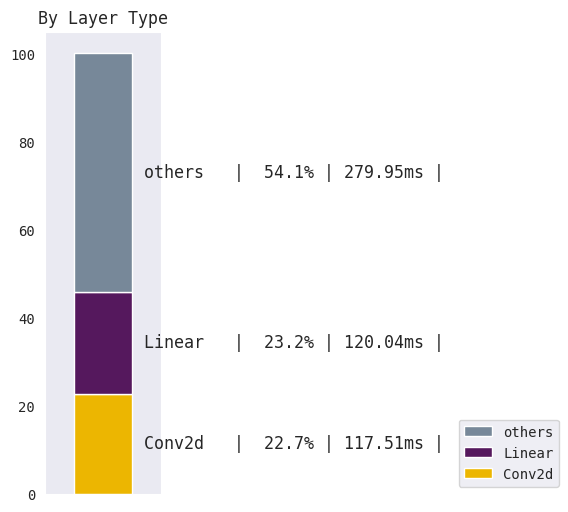

In [238]:
stacked_layer_summ = df_layer_summ[['scope', 'scope_percentage']]
stacked_layer_summ.set_index('scope', inplace=True)
stacked_layer_summ = stacked_layer_summ.reindex(index=stacked_layer_summ.index[::-1]).T
ax = stacked_layer_summ.plot.bar(stacked=True, color=colorlut, figsize=(1.5, 6), title = "By Layer Type")
ax.legend(loc='lower left', bbox_to_anchor=(3.5,0.0), reverse=True)
ax.axes.get_xaxis().set_visible(False)

for k, p in zip(stacked_layer_summ.columns, ax.patches):
    scope_mean = df_layer_summ.set_index('scope').loc[k, "scope_mean"]
    scope_pc = df_layer_summ.set_index('scope').loc[k, "scope_percentage"]

    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width+0.1, 
            y+height/2, 
            f'{k:8} | {scope_pc:5.1f}% | {scope_mean*1000:6.2f}ms | ', 
            horizontalalignment='left', 
            verticalalignment='center', size=12)

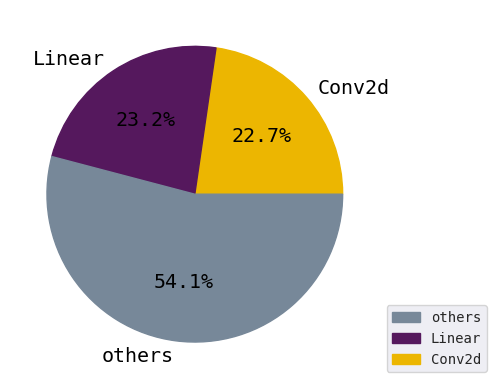

In [239]:
df_layer_summ_pie = df_layer_summ.sort_values("scope_mean").set_index("scope")
ax=df_layer_summ_pie.plot.pie(y="scope_mean", autopct='%.1f%%', textprops={'size': 'x-large', 'color':'black'})
ax.axes.get_yaxis().set_visible(False)

for k, p in zip(df_layer_summ_pie.index, ax.patches):
    p.set_color(colorlut[k])

# because we remap color, putting/updating legend at last will reflect new color
ax.legend(loc='lower left', bbox_to_anchor=(1,0.0), reverse=True)